##**Importing all the libraries**


In [ ]:
!pip install -q keras
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 79.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import imagehash
import shutil
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
#Setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

##**Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_path='/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/train'
test_path='/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test'

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255) # Normalize pixel values

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##**Image distribution in each directory**

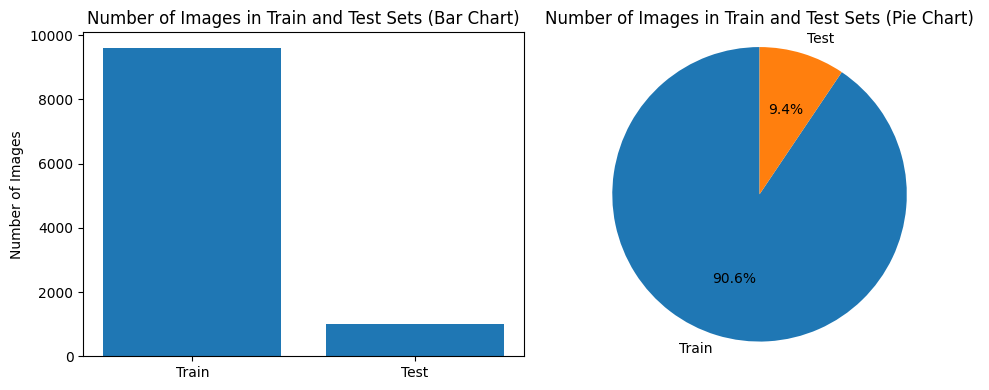

In [ ]:

# Get the total number of images in each set
train_count = len(train_generator.classes)
test_count = len(test_generator.classes)

# Data for the charts
labels = ['Train', 'Test']
sizes = [train_count, test_count]

# Create a figure and axes for the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Bar chart
ax1.bar(labels, sizes)
ax1.set_ylabel('Number of Images')
ax1.set_title('Number of Images in Train and Test Sets (Bar Chart)')

# Pie chart
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Number of Images in Train and Test Sets (Pie Chart)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()




*   From the bar graph, there are 9605 images belonging to Train dataset and 1000 images belonging to Test dataset.
*   From the pie chart, we see that 90.6% of total images belong to Train dataset and 9.4% belong to Test dataset






##**Class distribution**

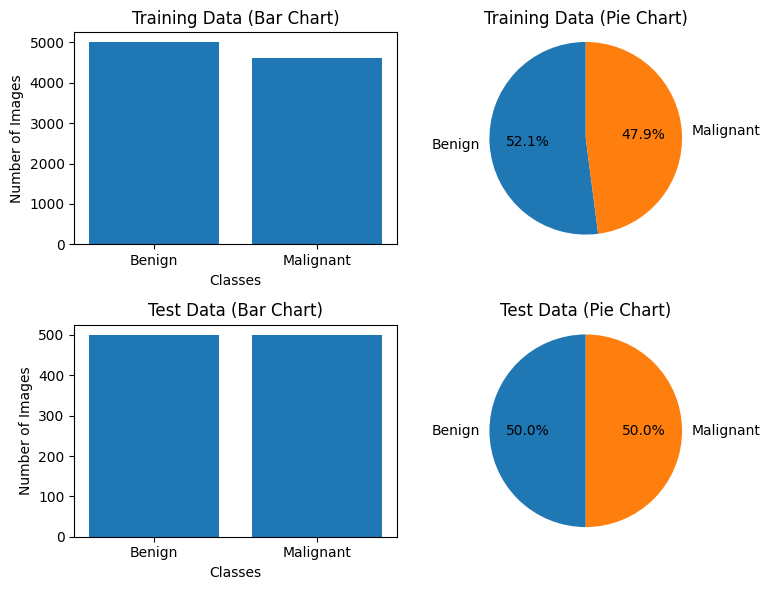

In [ ]:
# Training data counts
benign_count1 = len(train_generator.classes[train_generator.classes == 0])
malignant_count1 = len(train_generator.classes[train_generator.classes == 1])

# Test data counts
benign_count2 = len(test_generator.classes[test_generator.classes == 0])
malignant_count2 = len(test_generator.classes[test_generator.classes == 1])

# Labels for the charts
labels = ['Benign', 'Malignant']

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2 rows, 2 columns

# Training data bar chart
axes[0, 0].bar(labels, [benign_count1, malignant_count1])
axes[0, 0].set_xlabel('Classes')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].set_title('Training Data (Bar Chart)')

# Training data pie chart
axes[0, 1].pie([benign_count1, malignant_count1], labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].axis('equal')
axes[0, 1].set_title('Training Data (Pie Chart)')

# Test data bar chart
axes[1, 0].bar(labels, [benign_count2, malignant_count2])
axes[1, 0].set_xlabel('Classes')
axes[1, 0].set_ylabel('Number of Images')
axes[1, 0].set_title('Test Data (Bar Chart)')

# Test data pie chart
axes[1, 1].pie([benign_count2, malignant_count2], labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].axis('equal')
axes[1, 1].set_title('Test Data (Pie Chart)')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



*   Train dataset is slightly imbalanced
*   Test dataset is balanced



##**Corrupted image distribution**

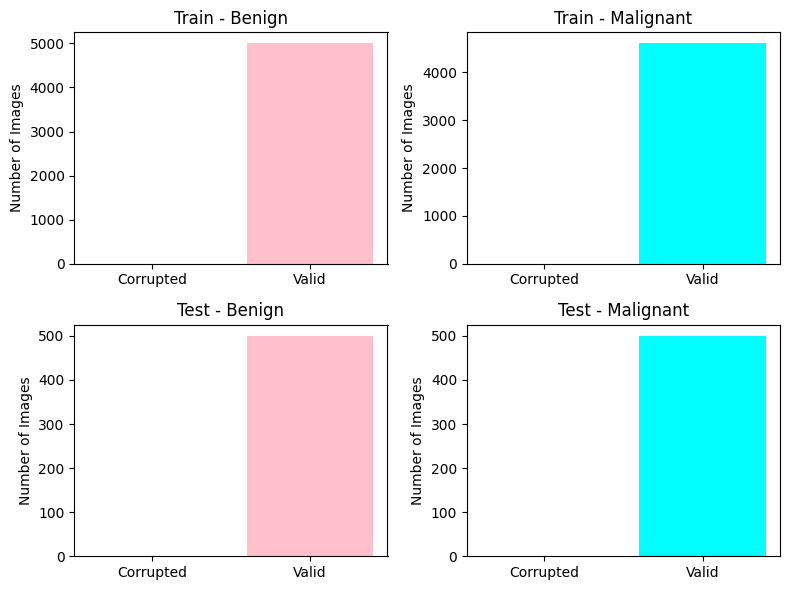

In [ ]:
def check_corrupted_images(folder_path):
    corrupted_count = 0
    total_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            total_count += 1
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify image integrity
            except (IOError, SyntaxError) as e:
                corrupted_count += 1
                print(f"Corrupted image: {img_path}")  # Print corrupted image paths

    return corrupted_count, total_count

# Paths to your datasets
train_benign_path = os.path.join(train_path, 'benign')
train_malignant_path = os.path.join(train_path, 'malignant')
test_benign_path = os.path.join(test_path, 'benign')
test_malignant_path = os.path.join(test_path, 'malignant')

# Check for corrupted images in each subset
train_benign_corrupted, train_benign_total = check_corrupted_images(train_benign_path)
train_malignant_corrupted, train_malignant_total = check_corrupted_images(train_malignant_path)
test_benign_corrupted, test_benign_total = check_corrupted_images(test_benign_path)
test_malignant_corrupted, test_malignant_total = check_corrupted_images(test_malignant_path)

# Create subplots for bar plots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# --- Bar plots ---
# Train benign
axes[0, 0].bar(['Corrupted', 'Valid'], [train_benign_corrupted, train_benign_total - train_benign_corrupted], color=['red', 'pink'])
axes[0, 0].set_title('Train - Benign')
axes[0, 0].set_ylabel('Number of Images')

# Train malignant (similar structure)
axes[0, 1].bar(['Corrupted', 'Valid'], [train_malignant_corrupted, train_malignant_total - train_malignant_corrupted], color=['red', 'cyan'])
axes[0, 1].set_title('Train - Malignant')
axes[0, 1].set_ylabel('Number of Images')

# Test benign (similar structure)
axes[1, 0].bar(['Corrupted', 'Valid'], [test_benign_corrupted, test_benign_total - test_benign_corrupted], color=['red', 'pink'])
axes[1, 0].set_title('Test - Benign')
axes[1, 0].set_ylabel('Number of Images')

# Test malignant (similar structure)
axes[1, 1].bar(['Corrupted', 'Valid'], [test_malignant_corrupted, test_malignant_total - test_malignant_corrupted], color=['red', 'cyan'])
axes[1, 1].set_title('Test - Malignant')
axes[1, 1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

None of the images are corrupted

##**Checking for the presence of duplicate image**

In [ ]:
def find_duplicates(image_dir):
    """Finds and prints duplicate images within a directory."""

    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append((image_hashes[hash], img_path))  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    # Print duplicates (original then duplicate below)
    '''if duplicates:
        print(f"Duplicates found in {image_dir}:")
        for original, duplicate in duplicates:
            print(f"Original: {original}")
            print(f"Duplicate: {duplicate}")
    else:
        print(f"No duplicates found in {image_dir}")'''

    return duplicates

# --- Run duplicate detection ---
datasets = [
    (os.path.join(train_path, 'benign'), "train_benign"),
    (os.path.join(train_path, 'malignant'), "train_malignant"),
    (os.path.join(test_path, 'benign'), "test_benign"),
    (os.path.join(test_path, 'malignant'), "test_malignant")
]
duplicate_counts = {}  # Store duplicate counts for each dataset

for dataset_path, dataset_name in datasets:
    duplicates = find_duplicates(dataset_path)
    duplicate_count = len(duplicates)
    duplicate_counts[dataset_name] = duplicate_count
    print(f"Number of duplicate images in {dataset_name}: {duplicate_count}")

Number of duplicate images in train_benign: 8
Number of duplicate images in train_malignant: 18
Number of duplicate images in test_benign: 1
Number of duplicate images in test_malignant: 0


##**Duplicate Image Distribution**

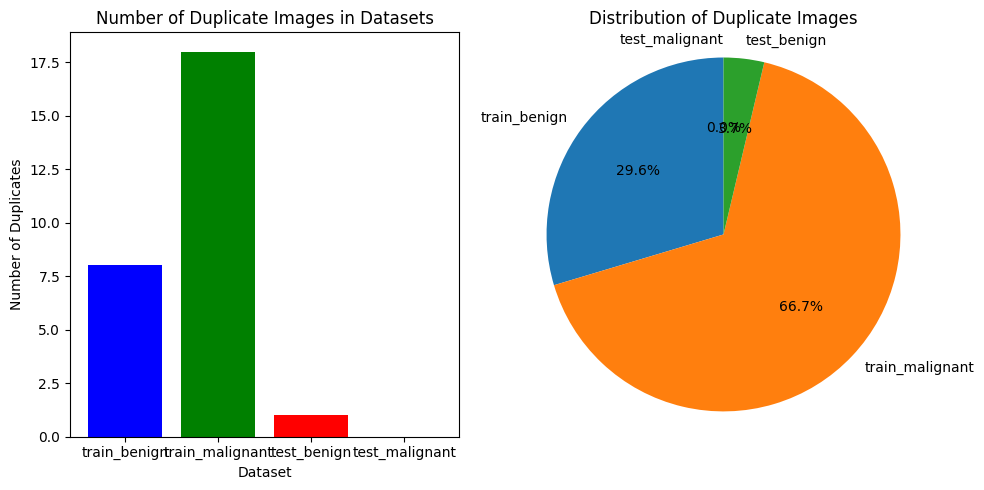

In [ ]:
# Create a figure and axes for the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Bar graph
ax1.bar(duplicate_counts.keys(), duplicate_counts.values(), color=['blue', 'green', 'red', 'purple'])
ax1.set_title('Number of Duplicate Images in Datasets')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Number of Duplicates')

# Pie chart
ax2.pie(duplicate_counts.values(), labels=duplicate_counts.keys(), autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Duplicate Images')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

##**Displaying a few duplicate images**

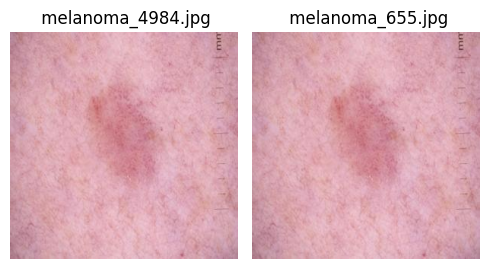

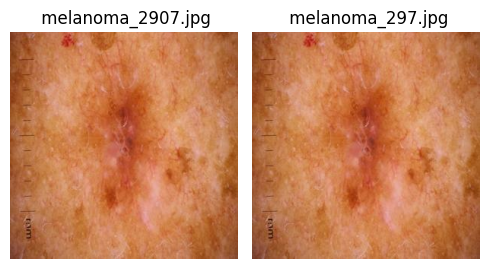

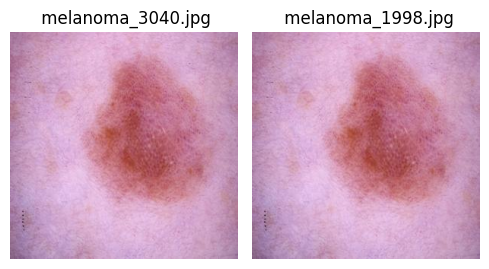

In [ ]:
def display_duplicates(image_dir, num_duplicates_to_display=3):
    """
    Finds and displays duplicate images within a directory.

    Args:
        image_dir: Path to the directory containing images.
        num_duplicates_to_display: Maximum number of duplicate sets to display.
    """

    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append((image_hashes[hash], img_path))  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    if duplicates:

        # Limit the number of duplicates to display
        duplicates_to_display = duplicates[:num_duplicates_to_display]

        for original, duplicate in duplicates_to_display:
            fig, axes = plt.subplots(1, 2, figsize=(5, 5))  # 1 row, 2 columns

            # Original image
            original_img = Image.open(original)
            axes[0].imshow(original_img)
            axes[0].set_title(f" {os.path.basename(original)}")
            axes[0].axis('off')

            # Duplicate image
            duplicate_img = Image.open(duplicate)
            axes[1].imshow(duplicate_img)
            axes[1].set_title(f" {os.path.basename(duplicate)}")
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

    else:
        print(f"No duplicates found in {image_dir}")


# Call the function to display duplicates (up to 3) from the 'train_benign' dataset:
display_duplicates(os.path.join(train_path, 'benign'))

##**Dropping the duplicate images**

In [ ]:
def remove_duplicates_and_store(original_dataset_path, new_dataset_path):
    """
    Removes duplicate images from a dataset and stores the unique images in a new folder.

    Args:
        original_dataset_path: Path to the original dataset.
        new_dataset_path: Path to the new dataset folder (will be created if it doesn't exist).
    """

    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    # Create the new dataset directory if it doesn't exist
    os.makedirs(new_dataset_path, exist_ok=True)

    for filename in os.listdir(original_dataset_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(original_dataset_path, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append(img_path)  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
                        # Copy unique image to the new dataset
                        shutil.copy(img_path, new_dataset_path)
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    print(f"Removed {len(duplicates)} duplicate images.")
    print(f"Unique images stored in: {new_dataset_path}")


new_dataset_path1 = '/content/drive/MyDrive/Data/Unique_train/original_unique/benign'
new_dataset_path2 = '/content/drive/MyDrive/Data/Unique_train/original_unique/malignant'

remove_duplicates_and_store(os.path.join(train_path, 'benign'), new_dataset_path1)
remove_duplicates_and_store(os.path.join(train_path, 'malignant'), new_dataset_path2)


Removed 8 duplicate images.
Unique images stored in: /content/drive/MyDrive/Data/Unique_train/original_unique/benign
Removed 18 duplicate images.
Unique images stored in: /content/drive/MyDrive/Data/Unique_train/original_unique/malignant


##**Displaying a few images**

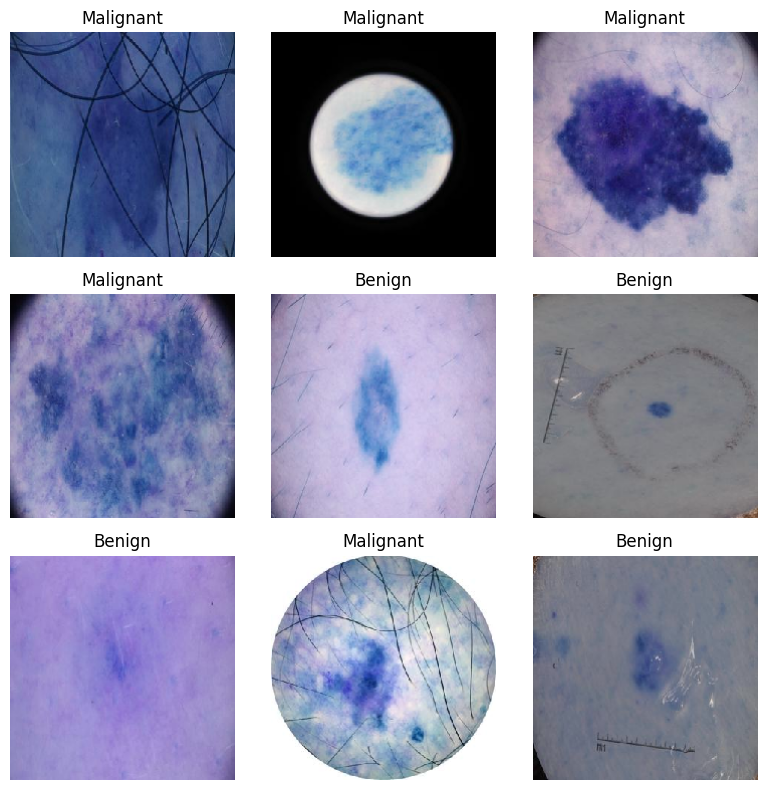

In [ ]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Display images in a grid
fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # 3 rows, 3 columns
for i in range(9):  # Display 9 images
    row = i // 3  # Calculate row index
    col = i % 3   # Calculate column index

    image = images[i]
    image_bgr = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)  # Convert to BGR

    axes[row, col].imshow(image_bgr)  # Display on the subplot
    axes[row, col].axis('off')  # Hide axes

    label_string = "Benign" if labels[i] == 0 else "Malignant"
    axes[row, col].set_title(label_string)  # Set title as label

plt.tight_layout()
plt.show()

##**Orientation analysis**

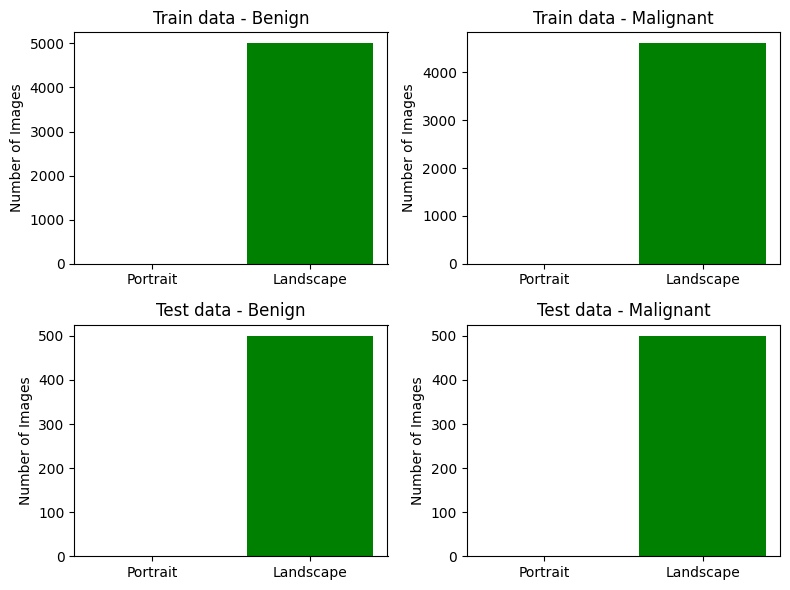

In [ ]:
def count_orientations(folder_path):
    portrait_count = 0
    landscape_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                width, height = img.size
                if height > width:
                    portrait_count += 1
                else:
                    landscape_count += 1

    return portrait_count, landscape_count

# Paths to your datasets
train_benign_path = os.path.join(train_path, 'benign')
train_malignant_path = os.path.join(train_path, 'malignant')
test_benign_path = os.path.join(test_path, 'benign')
test_malignant_path = os.path.join(test_path, 'malignant')

# Count orientations for each subset
train_benign_portrait, train_benign_landscape = count_orientations(train_benign_path)
train_malignant_portrait, train_malignant_landscape = count_orientations(train_malignant_path)
test_benign_portrait, test_benign_landscape = count_orientations(test_benign_path)
test_malignant_portrait, test_malignant_landscape = count_orientations(test_malignant_path)

# Create subplots for bar plots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# --- Bar plots ---
# Train benign
axes[0, 0].bar(['Portrait', 'Landscape'], [train_benign_portrait, train_benign_landscape], color=['blue', 'green'])
axes[0, 0].set_title('Train data - Benign')
axes[0, 0].set_ylabel('Number of Images')

# Train malignant (similar structure)
axes[0, 1].bar(['Portrait', 'Landscape'], [train_malignant_portrait, train_malignant_landscape], color=['blue', 'green'])
axes[0, 1].set_title('Train data - Malignant')
axes[0, 1].set_ylabel('Number of Images')

# Test benign (similar structure)
axes[1, 0].bar(['Portrait', 'Landscape'], [test_benign_portrait, test_benign_landscape], color=['blue', 'green'])
axes[1, 0].set_title('Test data - Benign')
axes[1, 0].set_ylabel('Number of Images')

# Test malignant (similar structure)
axes[1, 1].bar(['Portrait', 'Landscape'], [test_malignant_portrait, test_malignant_landscape], color=['blue', 'green'])
axes[1, 1].set_title('Test data - Malignant')
axes[1, 1].set_ylabel('Number of Images')


plt.tight_layout()
plt.show()

All the images are in landscape

##**Brightness distribution**

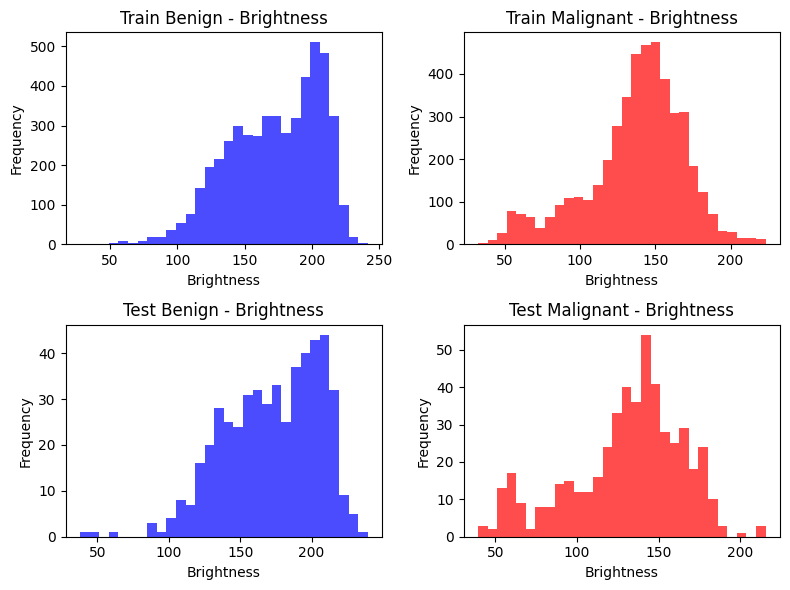

In [ ]:
def calculate_brightness_contrast(folder_path):
    brightness_values = []
    contrast_values = []
    labels = []

    for class_name in ['benign', 'malignant']:
        class_path = os.path.join(folder_path, class_name)
        label = 0 if class_name == 'benign' else 1

        for filename in os.listdir(class_path):
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is not None:
                    brightness = np.mean(img)
                    contrast = np.std(img)
                    brightness_values.append(brightness)
                    contrast_values.append(contrast)
                    labels.append(label)

    return brightness_values, contrast_values, labels

# Calculate brightness and contrast for each subset
train_brightness, train_contrast, train_labels = calculate_brightness_contrast(train_path)
test_brightness, test_contrast, test_labels = calculate_brightness_contrast(test_path)

# Create subplots for histograms/box plots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# --- Brightness ---
# Train benign
axes[0, 0].hist(np.array(train_brightness)[np.where(np.array(train_labels) == 0)], bins=30, alpha=0.7, label='Benign', color='blue')
axes[0, 0].set_title('Train Benign - Brightness')
axes[0, 0].set_xlabel('Brightness')
axes[0, 0].set_ylabel('Frequency')

# Train malignant
axes[0, 1].hist(np.array(train_brightness)[np.where(np.array(train_labels) == 1)], bins=30, alpha=0.7, label='Malignant', color='red')
axes[0, 1].set_title('Train Malignant - Brightness')
axes[0, 1].set_xlabel('Brightness')
axes[0, 1].set_ylabel('Frequency')

# Test benign
axes[1, 0].hist(np.array(test_brightness)[np.where(np.array(test_labels) == 0)], bins=30, alpha=0.7, label='Benign', color='blue')
axes[1, 0].set_title('Test Benign - Brightness')
axes[1, 0].set_xlabel('Brightness')
axes[1, 0].set_ylabel('Frequency')

# Test malignant
axes[1, 1].hist(np.array(test_brightness)[np.where(np.array(test_labels) == 1)], bins=30, alpha=0.7, label='Malignant', color='red')
axes[1, 1].set_title('Test Malignant - Brightness')
axes[1, 1].set_xlabel('Brightness')
axes[1, 1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()


The benign images are brighter than the malignant images for both the datasets

##**Image Shape**

In [ ]:
print("Image Shape:", images.shape)  # Get the shape of the images

Image Shape: (32, 224, 224, 3)


##**Image Size**

In [ ]:
# Open the image using PIL
image = Image.open('/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/train/benign/melanoma_4999.jpg')  # Replace with your image path

# Get the width and height of the image
width, height = image.size

# Print the image size
print(f"Image Size: {width} x {height}")

Image Size: 300 x 300


##**Image Size Distribution**

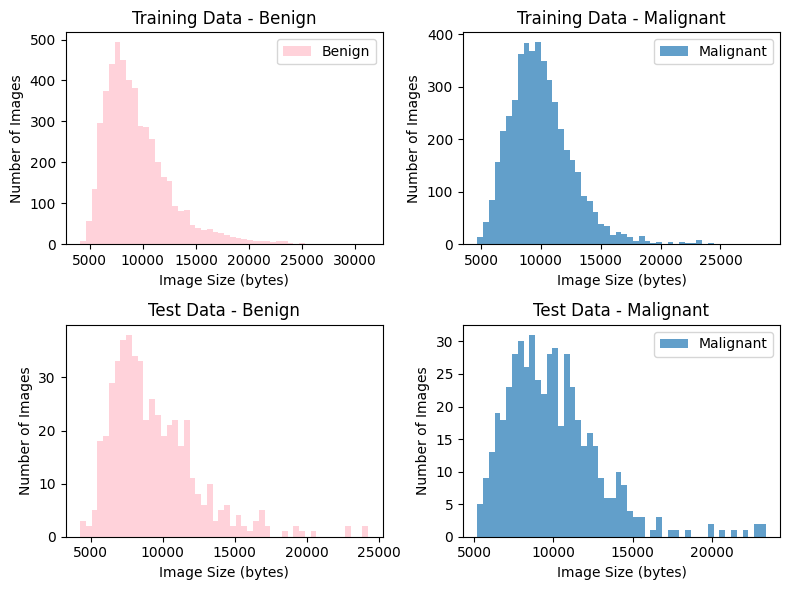

In [ ]:
def get_image_sizes(folder_path):
    image_sizes = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            image_sizes.append(os.path.getsize(img_path))
    return image_sizes

# Get image sizes for training and test sets (benign and malignant)
train_benign_sizes = get_image_sizes(os.path.join(train_path, 'benign'))
train_malignant_sizes = get_image_sizes(os.path.join(train_path, 'malignant'))
test_benign_sizes = get_image_sizes(os.path.join(test_path, 'benign'))
test_malignant_sizes = get_image_sizes(os.path.join(test_path, 'malignant'))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2 rows, 2 columns

# Training data histograms
axes[0, 0].hist(train_benign_sizes, bins=50, alpha=0.7, label='Benign', color='pink')
axes[0, 1].hist(train_malignant_sizes, bins=50, alpha=0.7, label='Malignant')
axes[0, 0].set_xlabel('Image Size (bytes)')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].set_title('Training Data - Benign')
axes[0, 0].legend()
axes[0, 1].set_xlabel('Image Size (bytes)')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].set_title('Training Data - Malignant')
axes[0, 1].legend()

# Test data histograms
axes[1, 0].hist(test_benign_sizes, bins=50, alpha=0.7, label='Benign', color='pink')
axes[1, 1].hist(test_malignant_sizes, bins=50, alpha=0.7, label='Malignant')
axes[1, 0].set_xlabel('Image Size (bytes)')
axes[1, 0].set_ylabel('Number of Images')
axes[1, 0].set_title('Test Data - Benign');
axes[1, 1].set_xlabel('Image Size (bytes)')
axes[1, 1].set_ylabel('Number of Images')
axes[1, 1].set_title('Test Data - Malignant')
axes[1, 1].legend()


plt.tight_layout()
plt.show()

Train data images have lower size (in bytes) compared to test data images

##**Aspect ratio analysis**

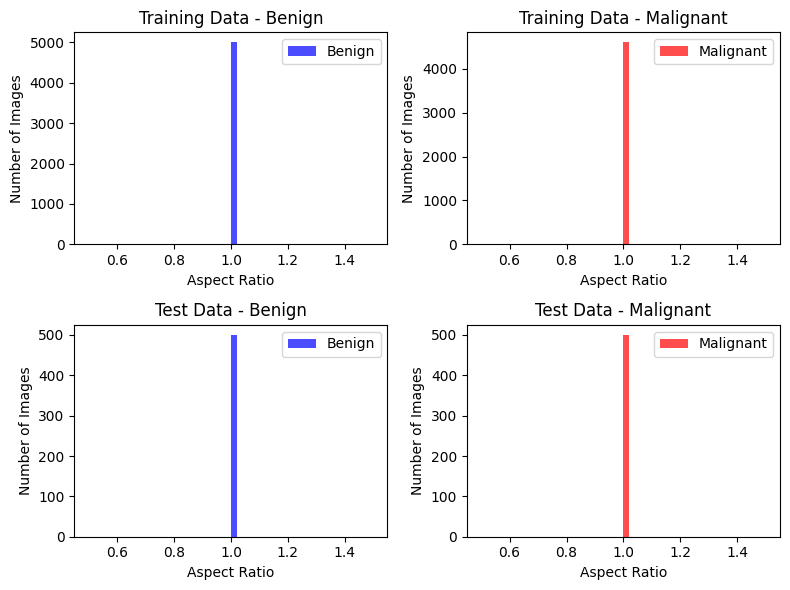

In [ ]:
def get_aspect_ratios(folder_path):
    aspect_ratios = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                width, height = img.size
                aspect_ratios.append(width / height)
    return aspect_ratios

# Get aspect ratios for training and test sets (benign and malignant)
train_benign_ratios = get_aspect_ratios(os.path.join(train_path, 'benign'))
train_malignant_ratios = get_aspect_ratios(os.path.join(train_path, 'malignant'))
test_benign_ratios = get_aspect_ratios(os.path.join(test_path, 'benign'))
test_malignant_ratios = get_aspect_ratios(os.path.join(test_path, 'malignant'))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2 rows, 2 columns

# Training data histograms
axes[0, 0].hist(train_benign_ratios, bins=50, alpha=0.7, label='Benign', color='blue')
axes[0, 1].hist(train_malignant_ratios, bins=50, alpha=0.7, label='Malignant', color='red')
axes[0, 0].set_xlabel('Aspect Ratio')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].set_title('Training Data - Benign')
axes[0, 0].legend()
axes[0, 1].set_xlabel('Aspect Ratio')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].set_title('Training Data - Malignant')
axes[0, 1].legend()

# Test data histograms
axes[1, 0].hist(test_benign_ratios, bins=50, alpha=0.7, label='Benign', color='blue')
axes[1, 1].hist(test_malignant_ratios, bins=50, alpha=0.7, label='Malignant', color='red')
axes[1, 0].set_xlabel('Aspect Ratio')
axes[1, 0].set_ylabel('Number of Images')
axes[1, 0].set_title('Test Data - Benign')
axes[1, 0].legend()
axes[1, 1].set_xlabel('Aspect Ratio')
axes[1, 1].set_ylabel('Number of Images')
axes[1, 1].set_title('Test Data - Malignant')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Height and width of all the images are equal

##**Image type distribution - RGB vs Grayscale**

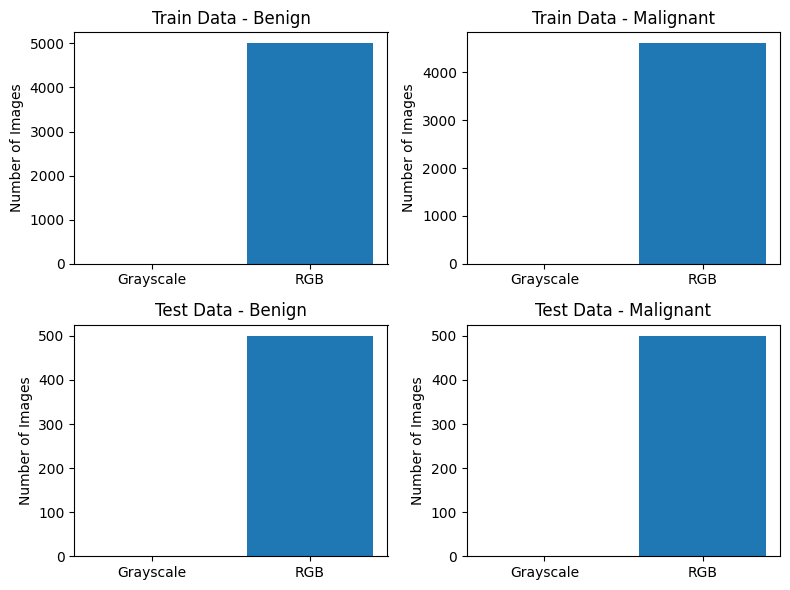

In [ ]:
def count_image_types(folder_path):
    grayscale_count = 0
    rgb_count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                if img.mode == 'L':
                    grayscale_count += 1
                elif img.mode == 'RGB':
                    rgb_count += 1
    return grayscale_count, rgb_count

# Count image types for each category
train_benign_grayscale, train_benign_rgb = count_image_types(os.path.join(train_path, 'benign'))
train_malignant_grayscale, train_malignant_rgb = count_image_types(os.path.join(train_path, 'malignant'))
test_benign_grayscale, test_benign_rgb = count_image_types(os.path.join(test_path, 'benign'))
test_malignant_grayscale, test_malignant_rgb = count_image_types(os.path.join(test_path, 'malignant'))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2 rows, 2 columns

# Bar chart for train-benign
axes[0, 0].bar(['Grayscale', 'RGB'], [train_benign_grayscale, train_benign_rgb])
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].set_title('Train Data - Benign')

# Bar chart for train-malignant
axes[0, 1].bar(['Grayscale', 'RGB'], [train_malignant_grayscale, train_malignant_rgb])
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].set_title('Train Data - Malignant')

# Bar chart for test-benign
axes[1, 0].bar(['Grayscale', 'RGB'], [test_benign_grayscale, test_benign_rgb])
axes[1, 0].set_ylabel('Number of Images')
axes[1, 0].set_title('Test Data - Benign')

# Bar chart for test-malignant
axes[1, 1].bar(['Grayscale', 'RGB'], [test_malignant_grayscale, test_malignant_rgb])
axes[1, 1].set_ylabel('Number of Images')
axes[1, 1].set_title('Test Data - Malignant')

plt.tight_layout()
plt.show()

All the images are in RGB. None of them are grayscaled.

##**Colour Distribution**

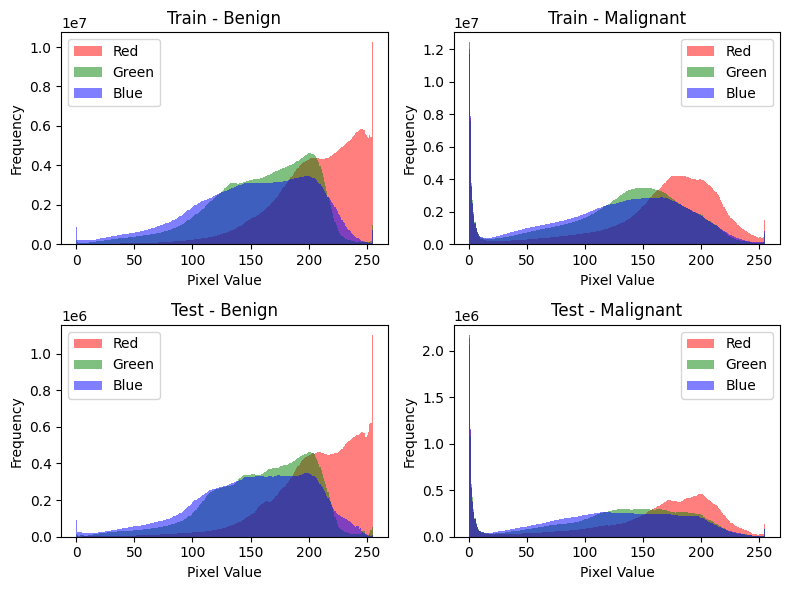

In [ ]:
def get_color_distribution(folder_path):
    all_pixels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                pixels = img.reshape(-1, 3)
                all_pixels.append(pixels)
    all_pixels = np.concatenate(all_pixels, axis=0)
    return all_pixels

# Paths to your datasets
train_benign_path = os.path.join(train_path, 'benign')
train_malignant_path = os.path.join(train_path, 'malignant')
test_benign_path = os.path.join(test_path, 'benign')
test_malignant_path = os.path.join(test_path, 'malignant')

# Get pixel data for each subset
train_benign_pixels = get_color_distribution(train_benign_path)
train_malignant_pixels = get_color_distribution(train_malignant_path)
test_benign_pixels = get_color_distribution(test_benign_path)
test_malignant_pixels = get_color_distribution(test_malignant_path)

# Create subplots for histograms
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# --- Color Distribution ---
# Train benign
axes[0, 0].hist(train_benign_pixels[:, 0], bins=256, color='red', alpha=0.5, label='Red')
axes[0, 0].hist(train_benign_pixels[:, 1], bins=256, color='green', alpha=0.5, label='Green')
axes[0, 0].hist(train_benign_pixels[:, 2], bins=256, color='blue', alpha=0.5, label='Blue')
axes[0, 0].set_title('Train - Benign')
axes[0, 0].set_xlabel('Pixel Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Train malignant (similar structure)
axes[0, 1].hist(train_malignant_pixels[:, 0], bins=256, color='red', alpha=0.5, label='Red')
axes[0, 1].hist(train_malignant_pixels[:, 1], bins=256, color='green', alpha=0.5, label='Green')
axes[0, 1].hist(train_malignant_pixels[:, 2], bins=256, color='blue', alpha=0.5, label='Blue')
axes[0, 1].set_title('Train - Malignant')
axes[0, 1].set_xlabel('Pixel Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Test benign (similar structure)
axes[1, 0].hist(test_benign_pixels[:, 0], bins=256, color='red', alpha=0.5, label='Red')
axes[1, 0].hist(test_benign_pixels[:, 1], bins=256, color='green', alpha=0.5, label='Green')
axes[1, 0].hist(test_benign_pixels[:, 2], bins=256, color='blue', alpha=0.5, label='Blue')
axes[1, 0].set_title('Test - Benign')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Test malignant (similar structure)
axes[1, 1].hist(test_malignant_pixels[:, 0], bins=256, color='red', alpha=0.5, label='Red')
axes[1, 1].hist(test_malignant_pixels[:, 1], bins=256, color='green', alpha=0.5, label='Green')
axes[1, 1].hist(test_malignant_pixels[:, 2], bins=256, color='blue', alpha=0.5, label='Blue')
axes[1, 1].set_title('Test - Malignant')
axes[1, 1].set_xlabel('Pixel Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()


plt.tight_layout()
plt.show()

The red colour is present more in all the images

##**Pixel Value Distribution**

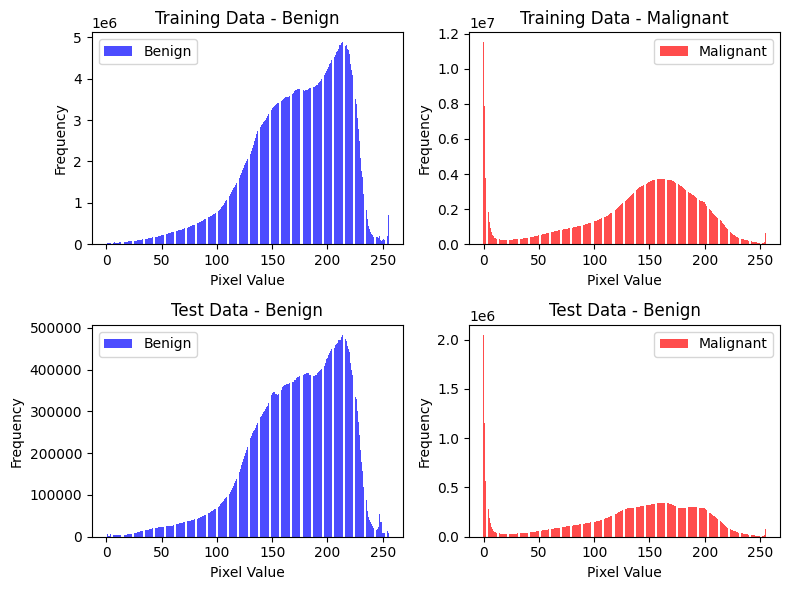

In [ ]:
def get_pixel_distribution(folder_path):
    pixel_counts = np.zeros(256, dtype=int)
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_np = np.array(img)
            hist, _ = np.histogram(img_np, bins=256, range=(0, 255))
            pixel_counts += hist
    return pixel_counts

# Get pixel distributions for training and test sets (benign and malignant)
train_benign_pixels = get_pixel_distribution(os.path.join(train_path, 'benign'))
train_malignant_pixels = get_pixel_distribution(os.path.join(train_path, 'malignant'))
test_benign_pixels = get_pixel_distribution(os.path.join(test_path, 'benign'))
test_malignant_pixels = get_pixel_distribution(os.path.join(test_path, 'malignant'))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2 rows, 2 columns

# Training data histograms
axes[0, 0].bar(range(256), train_benign_pixels, alpha=0.7, label='Benign', color='blue')
axes[0, 1].bar(range(256), train_malignant_pixels, alpha=0.7, label='Malignant', color='red')
axes[0, 0].set_xlabel('Pixel Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Training Data - Benign')
axes[0, 0].legend()
axes[0, 1].set_xlabel('Pixel Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Training Data - Malignant')
axes[0, 1].legend()

# Test data histograms
axes[1, 0].bar(range(256), test_benign_pixels, alpha=0.7, label='Benign', color='blue')
axes[1, 1].bar(range(256), test_malignant_pixels, alpha=0.7, label='Malignant', color='red')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Test Data - Benign')
axes[1, 0].legend()
axes[1, 1].set_xlabel('Pixel Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Test Data - Benign')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Benign images have higher pixel values compared to malignant images

##**Mean of pixel values per channel**

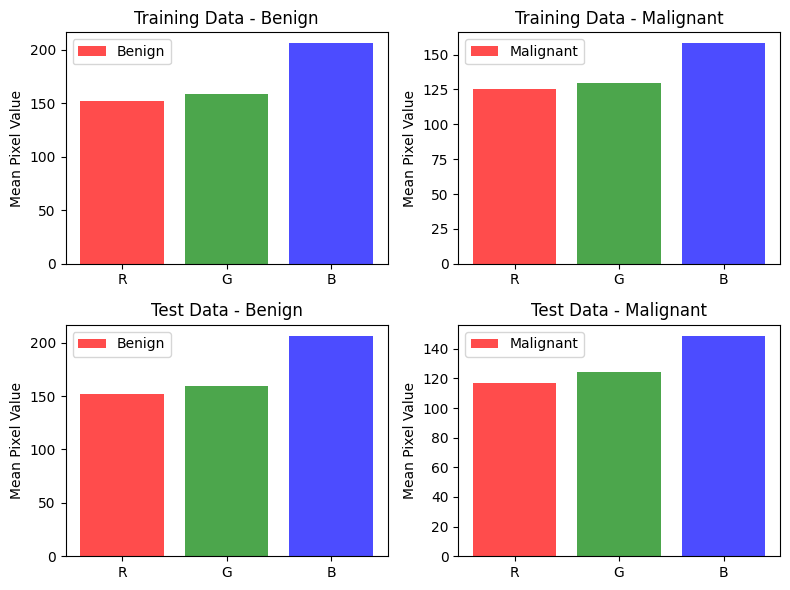

In [ ]:
def get_mean_std(folder_path):
    means = []
    stds = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            means.append(np.mean(img, axis=(0, 1)))  # Mean per channel
            stds.append(np.std(img, axis=(0, 1)))   # Standard deviation per channel
    return np.mean(means, axis=0), np.mean(stds, axis=0)

# Get mean and standard deviation for training and test sets (benign and malignant)
train_benign_mean, train_benign_std = get_mean_std(os.path.join(train_path, 'benign'))
train_malignant_mean, train_malignant_std = get_mean_std(os.path.join(train_path, 'malignant'))
test_benign_mean, test_benign_std = get_mean_std(os.path.join(test_path, 'benign'))
test_malignant_mean, test_malignant_std = get_mean_std(os.path.join(test_path, 'malignant'))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2 rows, 2 columns

# Training data plots (example for Mean)
axes[0, 0].bar(['R', 'G', 'B'], train_benign_mean, alpha=0.7, label='Benign', color=['red', 'green', 'blue'])
axes[0, 1].bar(['R', 'G', 'B'], train_malignant_mean, alpha=0.7, label='Malignant', color=['red', 'green', 'blue'])
axes[0, 0].set_ylabel('Mean Pixel Value')
axes[0, 0].set_title('Training Data - Benign')
axes[0, 0].legend()
axes[0, 1].set_ylabel('Mean Pixel Value')
axes[0, 1].set_title('Training Data - Malignant')
axes[0, 1].legend()

# Test data plots (example for Mean)
axes[1, 0].bar(['R', 'G', 'B'], test_benign_mean, alpha=0.7, label='Benign', color=['red', 'green', 'blue'])
axes[1, 1].bar(['R', 'G', 'B'], test_malignant_mean, alpha=0.7, label='Malignant', color=['red', 'green', 'blue'])
axes[1, 0].set_ylabel('Mean Pixel Value')
axes[1, 0].set_title('Test Data - Benign')
axes[1, 0].legend()
axes[1, 1].set_ylabel('Mean Pixel Value')
axes[1, 1].set_title('Test Data - Malignant')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

##**Normalization and Grayscaling**

In [ ]:
def rescale_normalize_grayscale(input_folder, output_folder):
    """
    Rescales, normalizes, and converts images to grayscale, maintaining
    the original folder structure (benign/malignant).

    Args:
        input_folder: Path to the folder containing original_unique.
        output_folder: Path to the folder for normalized_grayscaled.
    """
    os.makedirs(output_folder, exist_ok=True)  # Create output folder

    for class_name in ['benign', 'malignant']:
        class_input_folder = os.path.join(input_folder, class_name)
        class_output_folder = os.path.join(output_folder, class_name)
        os.makedirs(class_output_folder, exist_ok=True)  # Create class subfolder

        for filename in os.listdir(class_input_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(class_input_folder, filename)
                img = cv2.imread(img_path)

                if img is not None:
                    # Convert to grayscale
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Rescale to [0, 1]
                    gray_img = gray_img.astype(np.float32) / 255.0

                    # Normalize (standardization)
                    normalized_img = (gray_img - np.mean(gray_img)) / np.std(gray_img)

                    # Rescale normalized image to [0, 255] for saving
                    normalized_img = ((normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min()) * 255).astype(np.uint8)

                    # Save to output folder with original class structure
                    output_path = os.path.join(class_output_folder, filename)
                    cv2.imwrite(output_path, normalized_img)

# Define paths
original_unique_path = '/content/drive/MyDrive/Data/Unique_train/original_unique'
normalized_grayscaled_path = '/content/drive/MyDrive/Data/Unique_train/normalized_grayscaled'

# Process the images
rescale_normalize_grayscale(original_unique_path, normalized_grayscaled_path)

print("Normalization and grayscaling completed.")

Normalization and grayscaling completed.


**Displaying a few normalized and grayscaled images**

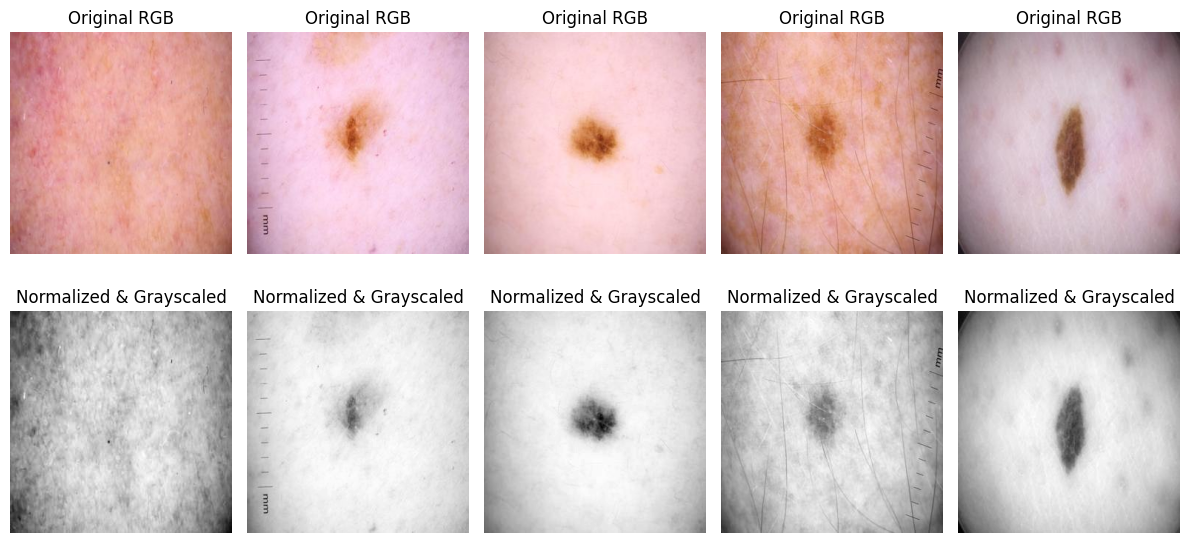

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Paths to the folders
unique_train_path = '/content/drive/MyDrive/Data/Unique_train/original_unique/benign'
unique_train_normalized_grayscaled_path = '/content/drive/MyDrive/Data/Unique_train/normalized_grayscaled/benign'

# Number of images to display
num_images_to_display = 5

# Get a list of image filenames from the 'unique_train' folder
image_filenames = os.listdir(unique_train_path)[:num_images_to_display]

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, num_images_to_display, figsize=(12, 6))

# Display the images
for i, filename in enumerate(image_filenames):
    # Original image
    original_img_path = os.path.join(unique_train_path, filename)
    original_img = cv2.imread(original_img_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
    axes[0, i].imshow(original_img_rgb)
    axes[0, i].set_title('Original RGB')
    axes[0, i].axis('off')

    # Normalized and grayscaled image
    normalized_grayscaled_img_path = os.path.join(unique_train_normalized_grayscaled_path, filename)
    normalized_grayscaled_img = cv2.imread(normalized_grayscaled_img_path, cv2.IMREAD_GRAYSCALE)
    axes[1, i].imshow(normalized_grayscaled_img, cmap='gray')
    axes[1, i].set_title('Normalized & Grayscaled')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

##**Data Augmentation**

In [ ]:
def augment_images(input_folder, output_folder, num_augmentations=3):
    """
    Augments images from the input folder and saves them to the output folder,
    maintaining the original benign/malignant structure.

    Args:
        input_folder: Path to the folder containing normalized_grayscaled.
        output_folder: Path to the folder for augmented images.
        num_augmentations: Number of augmentations to create per image (default 5).
    """
    os.makedirs(output_folder, exist_ok=True)  # Create output folder

    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_name in ['benign', 'malignant']:
        class_input_folder = os.path.join(input_folder, class_name)
        class_output_folder = os.path.join(output_folder, class_name)
        os.makedirs(class_output_folder, exist_ok=True)  # Create class subfolder

        for filename in os.listdir(class_input_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(class_input_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

                # Reshape to (1, height, width, 1) for ImageDataGenerator
                img = img.reshape((1,) + img.shape + (1,))

                # Generate and save augmented images with suffix 'aug_n'
                for i in range(num_augmentations):
                    augmented_img = datagen.random_transform(img[0])  # Apply random transformation
                    augmented_img_path = os.path.join(class_output_folder, f'{filename[:-4]}_aug_{i}.jpg')
                    cv2.imwrite(augmented_img_path, augmented_img)

# Define paths
normalized_grayscaled_path = '/content/drive/MyDrive/Data/Unique_train/normalized_grayscaled'
augmented_images_path1 = '/content/drive/MyDrive/Data/Unique_train/augmented_normalized_grayscaled'
augmented_images_path2 = '/content/drive/MyDrive/Data/Unique_train/augmented_original_rgb'
original_unique_path = '/content/drive/MyDrive/Data/Unique_train/original_unique'


# Augment the images
#augment_images(normalized_grayscaled_path, augmented_images_path1)
augment_images(original_unique_path, augmented_images_path2)

print("Augmentation completed.")

Augmentation completed.


**Displaying augmented images**

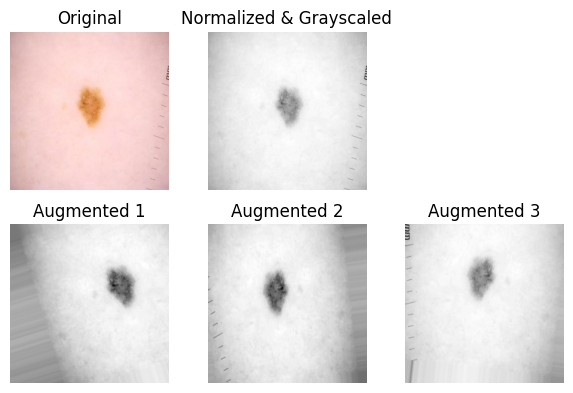

In [ ]:
normalized_grayscaled_path = '/content/drive/MyDrive/Data/Unique_train/normalized_grayscaled'
original_unique_path = '/content/drive/MyDrive/Data/Unique_train/original_unique'
augmented_images_path = '/content/drive/MyDrive/Data/Unique_train/augmented_normalized_grayscaled'

# Assuming 'filename' is defined and points to a specific image file
filename = 'melanoma_0.jpg'  # Replace with the actual filename
original_img_path = os.path.join(original_unique_path, 'benign', filename)  # Assuming 'benign' class
original_img = cv2.imread(original_img_path) # Read the original image

normalized_grayscaled_img_path = os.path.join(normalized_grayscaled_path, 'benign', filename)
normalized_grayscaled_img = cv2.imread(normalized_grayscaled_img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 4))

# 1st row: Original and Normalized/Grayscaled
plt.subplot(2, 6, 1)  # 2 rows, 6 columns, 1st position
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)) # Now original_img is defined
plt.title('Original')
plt.axis('off')

plt.subplot(2, 6, 2)  # 2 rows, 6 columns, 2nd position
plt.imshow(normalized_grayscaled_img, cmap='gray')
plt.title('Normalized & Grayscaled')
plt.axis('off')

# 2nd row: Augmented images
for i in range(3):
    augmented_img_path = os.path.join(augmented_images_path, "benign", f'{filename[:-4]}_aug_{i}.jpg')
    augmented_img = cv2.imread(augmented_img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 6, i + 7)  # Start from the 7th position in the 2nd row
    plt.imshow(augmented_img, cmap='gray')
    plt.title(f'Augmented {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

##**Model development**

**Model run on original RGB image dataset**

In [ ]:
# Define paths
train_data_dir = '/content/drive/MyDrive/Data/Unique_train/original_unique'  # Path containing 'Unique_train_benign' and 'Unique_train_malignant'
test_path = '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test' # Path containing 'benign' and 'malignant'

# Data preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Data preprocessing for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=4,  # Adjust as needed
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 9579 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 199s 479ms/step - accuracy: 0.7380 - loss: 0.5353 - val_accuracy: 0.8730 - val_loss: 0.2851
Epoch 2/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 145s 472ms/step - accuracy: 0.8661 - loss: 0.3217 - val_accuracy: 0.8920 - val_loss: 0.2696
Epoch 3/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 144s 467ms/step - accuracy: 0.8801 - loss: 0.2951 - val_accuracy: 0.8970 - val_loss: 0.2447
Epoch 4/4
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 465ms/step - accuracy: 0.8789 - loss: 0.2893 - val_accuracy: 0.8980 - val_loss: 0.2440
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9041 - loss: 0.2277
Test Loss: 0.2440
Test Accuracy: 0.8980


**Model trained on normalized and grayscaled image dataset**

In [ ]:
# Define paths
unique_train_normalized_grayscaled_path = '/content/drive/MyDrive/Data/Unique_train/normalized_grayscaled'
test_path = '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test'

# Create ImageDataGenerators for training and testing with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    unique_train_normalized_grayscaled_path,
    target_size=(128, 128),  # Adjust target size if needed
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'  # Set color mode to grayscale
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'  # Set color mode to grayscale
)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Lower learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)


Found 9579 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1912s 6s/step - accuracy: 0.7253 - loss: 1.3307 - val_accuracy: 0.5340 - val_loss: 1.2981 - learning_rate: 1.0000e-04
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 86s 172ms/step - accuracy: 0.7959 - loss: 1.1108 - val_accuracy: 0.7800 - val_loss: 1.1042 - learning_rate: 1.0000e-04
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - accuracy: 0.8049 - loss: 1.0488 - val_accuracy: 0.7490 - val_loss: 1.1107 - learning_rate: 1.0000e-04
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.8222 - loss: 1.0050 - val_accuracy: 0.8260 - val_loss: 1.0127 - learning_rate: 1.0000e-04
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.8387 - loss: 0.9465 - val_accuracy: 0.8430 - val_loss: 0.9343 - learning_rate: 1.0000e-04
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 53s 172ms/step - accuracy: 0.8399 - loss: 0.9224 - val_accuracy: 0.8490 - val_loss: 0.9010 - learning_rate: 1.0000e-04
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - a

**Model trained on normalized grayscaled augmented images**

In [ ]:
# Define the data augmentation for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load train and test datasets
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/Unique_train/augmented_normalized_grayscaled',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),


    GlobalAveragePooling2D(),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)


Found 25476 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
796/797 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7205 - loss: 0.7637 
Epoch 1: val_accuracy improved from -inf to 0.73000, saving model to best_model.keras
797/797 ━━━━━━━━━━━━━━━━━━━━ 4786s 6s/step - accuracy: 0.7206 - loss: 0.7635 - val_accuracy: 0.7300 - val_loss: 0.7239 - learning_rate: 1.0000e-04
Epoch 2/10
796/797 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8080 - loss: 0.6167
Epoch 2: val_accuracy improved from 0.73000 to 0.83400, saving model to best_model.keras
797/797 ━━━━━━━━━━━━━━━━━━━━ 143s 178ms/step - accuracy: 0.8080 - loss: 0.6166 - val_accuracy: 0.8340 - val_loss: 0.5852 - learning_rate: 1.0000e-04
Epoch 3/10
796/797 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8206 - loss: 0.5759
Epoch 3: val_accuracy did not improve from 0.83400
797/797 ━━━━━━━━━━━━━━━━━━━━ 147s 183ms/step - accuracy: 0.8207 - loss: 0.5759 - val_accuracy: 0.7820 - val_loss: 0.6431 - learning_rate: 1.0000e-04
Epoch 4/10
796/797 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0

**Model trained on original rgb augmented images**

In [ ]:
# Define paths
train_data_dir = '/content/drive/MyDrive/Data/Unique_train/augmented_original_rgb'  # Path containing 'Unique_train_benign' and 'Unique_train_malignant'
test_path = '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test' # Path containing 'benign' and 'malignant'

# Data preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Data preprocessing for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Found 19855 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


621/621 ━━━━━━━━━━━━━━━━━━━━ 2381s 3s/step - accuracy: 0.7937 - loss: 0.4472 - val_accuracy: 0.8380 - val_loss: 0.3603
Epoch 2/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 353s 494ms/step - accuracy: 0.8712 - loss: 0.3147 - val_accuracy: 0.8460 - val_loss: 0.3820
Epoch 3/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 318s 489ms/step - accuracy: 0.8765 - loss: 0.3090 - val_accuracy: 0.8300 - val_loss: 0.3722
Epoch 4/10
621/621 ━━━━━━━━━━━━━━━━━━━━ 324s 492ms/step - accuracy: 0.8813 - loss: 0.2904 - val_accuracy: 0.8330 - val_loss: 0.4062
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.8540 - loss: 0.3260
Test Loss: 0.3603
Test Accuracy: 0.8380


**VGG16**

In [ ]:
# Paths
train_path = '/content/drive/MyDrive/Data/Unique_train/augmented_original_rgb'
test_path = '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


In [ ]:
# Paths
train_path = '/content/drive/MyDrive/Data/Unique_train/augmented_normalized_grayscaled'
test_path = '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb',
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


Found 25476 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 843/1593 ━━━━━━━━━━━━━━━━━━━━ 2:43:03 13s/step - accuracy: 0.7099 - loss: 0.5747

In [ ]:
model.save("melanoma_model.h5")

**VGG19**

In [ ]:
# Paths
train_path =  '/content/drive/MyDrive/Data/Unique_train/augmented_normalized_grayscaled'
test_path = '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # Validation split
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


In [ ]:
# Paths
train_path =  '/content/drive/MyDrive/Data/Unique_train/augmented_original_rgb'
test_path = '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # Validation split
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

# Load VGG16 model pretrained on ImageNet
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 ━━━━━━━━━━━━━━━━━━━━ 2317s 9s/step - accuracy: 0.6547 - loss: 0.6214 - val_accuracy: 0.8261 - val_loss: 0.4174 - learning_rate: 1.0000e-04
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 157s 639ms/step - accuracy: 0.7827 - loss: 0.4613 - val_accuracy: 0.8470 - val_loss: 0.3737 - learning_rate: 1.0000e-04
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 199s 630ms/step - accuracy: 0.8088 - loss: 0.4248 - val_accuracy: 0.8548 - val_loss: 0.3551 - learning_rate: 1.0000e-04
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 155s 627ms/step - accuracy: 0.8191 - loss: 0.4029 - val_accuracy: 0.8522 - val_loss: 0.3436 - learning_rate: 1.0000e-04
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 202s 631ms/step - accuracy: 0.8276 - loss: 0.3791 - val_accuracy: 0.8293 - val_loss: 0.3681 - learning_rate: 1.0000e-04
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 155s 632ms/step - accuracy: 0.8492 - loss: 0.3555 - val_accuracy: 0.8558 - val_loss: 0.3508 - learning_rate: 1.0000e-04
Epoch 7/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step

##**Accuracy table**

In [ ]:
import pandas as pd

# Create the DataFrame
data = {'Model': ['CNN', 'CNN', 'CNN', 'CNN', 'VGG16', 'VGG16', 'VGG19', 'VGG19'],
        'Trained on Dataset': ['Original RGB', 'Normalized and Grayscaled', 'Augmented Normalized and Grayscaled', 'Augmented Original RGB', 'Augmented Normalized and Grayscaled', 'Augmented Original RGB', 'Augmented Normalized and Grayscaled', 'Augmented Original RGB'],
        'Accuracy': [89.80, 85.29, 83.39, 88.40, 90.40, 89.80, 88.80, 85.70]}
df = pd.DataFrame(data)

# Style the table
styled_table = df.style.set_properties(**{'border': '2px solid black',  # Set dark outlines
                                           'text-align': 'center'})  # Center align text

# Display the styled table
styled_table

,Model,Trained on Dataset,Accuracy
0,CNN,Original RGB,89.800000
1,CNN,Normalized and Grayscaled,85.290000
2,CNN,Augmented Normalized and Grayscaled,83.390000
3,CNN,Augmented Original RGB,88.400000
4,VGG16,Augmented Normalized and Grayscaled,90.400000
5,VGG16,Augmented Original RGB,89.800000
6,VGG19,Augmented Normalized and Grayscaled,88.800000
7,VGG19,Augmented Original RGB,85.700000


**Accuracy of VGG16 on Augmented Normalized and Grayscaled data is maximum (90.4%). Hence, it is the best model**

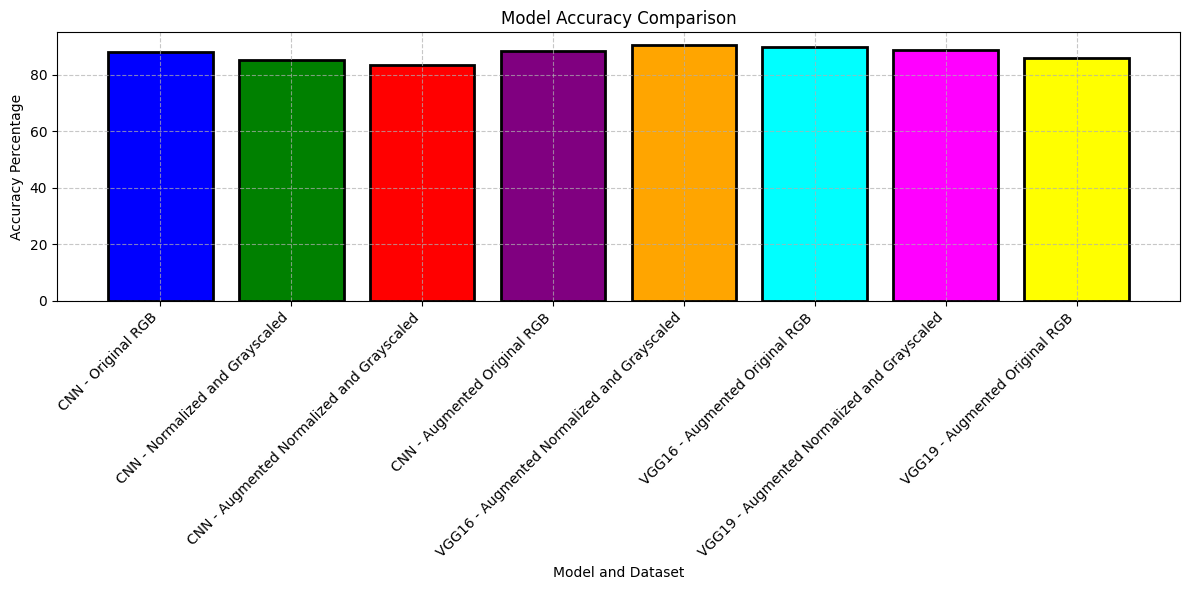

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the DataFrame
models = df['Model'] + ' - ' + df['Trained on']  # Combine Model and Trained on for labels
accuracy = df['Accuracy Percentage']

# Create the bar graph
plt.figure(figsize=(12, 6))  # Adjust figure size
plt.bar(models, accuracy, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow'], edgecolor='black', linewidth=2)

plt.xlabel("Model and Dataset")
plt.ylabel("Accuracy Percentage")
plt.title("Model Accuracy Comparison")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

##**Confusion matrix of the model with the highest accuracy**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 664s 21s/step


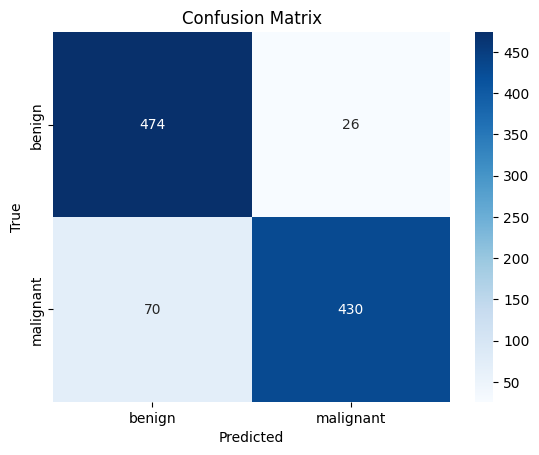

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/My Drive/Data/Unique_train/melanoma_model.h5'



test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Data/archive (1)/melanoma_cancer_dataset/test',  # Replace with the test data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Maintain the order of samples for confusion matrix
)


model = load_model(model_path)  # Replace with the path to your file

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = test_generator.classes  # True labels

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




##**Classification Report**

In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


Classification Report:
              precision    recall  f1-score   support

      benign       0.87      0.95      0.91       500
   malignant       0.94      0.86      0.90       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000

